<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab BedParcelInitializer components to initialize river bed sediment parcels for the NetworkSedimentTransporter component

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to initialize bed sediment to model the transport of coarse sediment through a river network using the NetworkSedimentTransporter Landlab component. 

In this example we will: 
- load a river network shapefile to create a Landlab grid to represent a river network
- initialize sediment 'parcels' on that river network using the four available BedParcelInitializer components
- conduct a simple exploration of the initial parcel attributes

Import the necessary libraries, plus a bit of magic so that we can plot within this notebook:

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy.constants
from landlab.components import BedParcelInitializerDischarge, BedParcelInitializerDepth, BedParcelInitializerArea, BedParcelInitializerUserD50
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab import ExampleData

from landlab.plot import plot_network_and_parcels
%matplotlib inline

## 1. Load a shapefile that represents the river network

First, we need to create a Landlab NetworkModelGrid to represent the river network. Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes. 

In [2]:
datadir = ExampleData("io/shapefile", case="redb").base

shp_file =datadir/"a001_network.shp"
points_shapefile = datadir/"a001_nodes_att.shp"

grid = read_shapefile(
    shp_file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_m2", "elev_m"],
    link_fields=["usarea_km2", "Length_m", "Slope"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_m2": "drainage_area_m2",
        "elev_m": "topographic__elevation",
    },
    threshold=0.01,
    )

C:\ProgramData\Anaconda3\envs\landlab_dev\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Let's plot our simple network: 

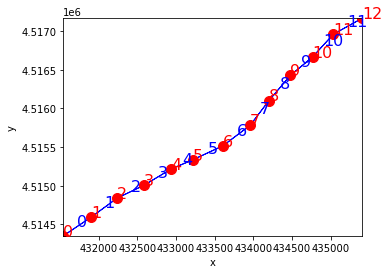

In [3]:
graph.plot_graph(grid, at="node,link")

Our network consists of 12 links (`grid.number_of_links`) between 13 nodes (`grid.number_of_nodes`). In the plot above, X and Y represent the plan-view coordinates of the node locations. 

Next, we need to populate the grid with the relevant topographic and hydrologic information: 

In [4]:
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy()

grid.at_link["channel_width"] = 1 * np.ones(grid.number_of_links) # m

grid.at_link["flow_depth"] = 0.5 * np.ones(grid.number_of_links) # m

We must distinguish between topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment).

## 2. Create initial sediment 'parcels' in a DataRecord

We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/data_record/DataRecord_tutorial.ipynb">DataRecord</a>. 

There are four available components for initiating bed sediment parcels, each of which take different parameters to determine the initial median grain size (d50) of the bed sediment. All initializers return a DataRecord of parcels with a set of parcels with a lognormal distribution of parcel grain sizes. By default, the d84 is 2.1 times d50, though the user can change the with of the grain size distribution. 

#### 1. BedParcelInitializerDischarge: set d50 via link discharge and Manning's _n_ roughness
We calculate initial sediment median grain size (d50) for each link using dominant discharge and channel width (via the Snyder et al.(2013) formula). Total parcel volume is function of active layer thickness, which is estimated from grain size (d84). We calculate the parcel volume by setting minimum number of parcels as 100. 
Let's create arrays with all of the essential sediment parcel variables by running the Landlab utility BedParcelInitializer: 

In [5]:
discharge_at_link = np.full(grid.number_of_links, 80.0)

initialize_parcels = BedParcelInitializerDischarge(grid,
                                           discharge_at_link = discharge_at_link
                                         )
parcels = initialize_parcels()

c:\users\pfeiffa\documents\github\landlab\landlab\components\network_sediment_transporter\bed_parcel_initializers.py:86: UserWarning: calculated d50 is unrealistically large ({d50} m)
  warnings.warn("calculated d50 is unrealistically large ({d50} m)")


See the warning? Let's check the maximum median grain size..

In [6]:
D50 = parcels.calc_aggregate_value(
            xr.Dataset.median,
            "D",
            at="link",
            fill_value=0.0
        )

np.max(D50)

5.4662416965736407

Yes, a >4 m median grain size is almost certainly not the kind of channel we were trying to model. 

Other notes: channel width is passed to the component via the NetworkModelGrid.  Above, we let the component use the default Manning's _n_ roughness value, 0.035, and critical Shields stress, 0.04. We could change that, or other parameters, if we want: 

In [7]:
discharge_at_link = np.full(grid.number_of_links, 1.0)

initialize_parcels = BedParcelInitializerDischarge(grid,
                                           discharge_at_link = discharge_at_link, 
                                           mannings_n = 0.05, 
                                           tau_c_50 = 0.08, 
                                           std_dev = 3, #a wider grain size distribution
                                         )
parcels = initialize_parcels()

#### 2. BedParcelInitializerDepth: set $D_{50}$ via link flow depth, channel slope, and Shields stress
We calculate initial sediment median grain size (d50) for each link using a formative (e.g. bankfull) flow depth, as in Pfeiffer et al. (2017). The user can change critical Shields stress and a "multiplier" as well, the default values of which are 0.04 and 1, respectively.  

In [8]:
depth= np.full(grid.number_of_links, 0.3)
initialize_parcels = BedParcelInitializerDepth(grid,
                                          flow_depth_at_link = depth,
                                          )
parcels = initialize_parcels()

As with the Discharge method above, here channel slope is passed to the parcel initializer via the grid. 

#### 3. BedParcelInitializerArea: set $D_{50}$ via hydraulic geometry scaling with drainage area
We calculate initial median sediment grain size (d50) for each link using a power law scaling relationship with drainage area. Other parcel attributes as above. 

In [9]:
initialize_parcels = BedParcelInitializerArea(grid,
                                          drainage_area_coefficient = 0.1,
                                          drainage_area_exponent = 0.3
                                          )

parcels = initialize_parcels()


#### 3. BedParcelInitializerUserD50: 

The user can specify either a d50 for each link in the network, or a single d50 for all links. 

In [10]:
d50_each_link= np.full(grid.number_of_links, 80.0)
# or
single_d50 = 0.05

initialize_parcels = BedParcelInitializerUserD50(grid,
                                          # user_d50 = d50_each_link,
                                          user_d50 = single_d50
                                          )

parcels = initialize_parcels()

#### Many options available for specifying $D_{50}$


In [11]:
date =  '2017-11-08 17:50:00'
starting_time = pd.to_datetime(date)

time = [starting_time]  

depth = np.full(grid.number_of_links, 1.2)
slope_depend_Shields = 0.15*grid.at_link['channel_slope']**0.25
tau_c_multiplier = 2.3 

initialize_parcels = BedParcelInitializerDepth(grid,
                                          flow_depth_at_link = depth,
                                          tau_c_50=slope_depend_Shields,
                                          tau_c_multiplier = tau_c_multiplier,
                                          median_number_of_starting_parcels= 100,
                                          extra_parcel_attributes = ['lithology','Be10_c']
                                          )

parcels = initialize_parcels()

parcels.dataset['lithology'].values = np.full(parcels.number_of_items,'quartzite')
parcels.dataset['Be10_c'].values = np.full(parcels.number_of_items,'222.2')

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which is a normalized value ranging from 0 to 1) according to a sediment transport formula. 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. 
We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time.
With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

## 3. Plot to explore starting parcels

What grain size did we end up with? How many parcels per link (check)? Etc. 

First, how many parcels are on the network?

In [12]:
number_of_pacels = parcels.number_of_items
number_of_pacels

1129

What are the parcel volumes?

In [13]:
print('The largest parcels is', np.round(np.max(parcels.dataset["volume"].values),3), 'm^3')
print('The median parcels is', np.round(np.median(parcels.dataset["volume"].values),3), 'm^3')
print('The smallest parcels is', np.round(np.min(parcels.dataset["volume"].values),3), 'm^3')

The largest parcels is 8.929 m^3
The median parcels is 8.929 m^3
The smallest parcels is 0.249 m^3


Next, what is the median grain size at each link? 

*Note: we're not weighting the calculation by parcel volume, which is a trivial simplification since nearly all parcels are the same volume*

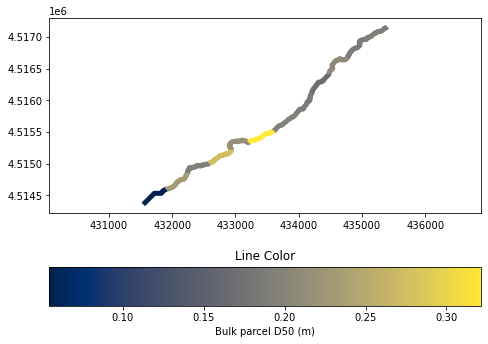

In [14]:
D50 = parcels.calc_aggregate_value(
            xr.Dataset.median,
            "D",
            at="link",
            fill_value=0.0
        )

fig = plot_network_and_parcels(
    grid, parcels,
    link_attribute=D50, 
    link_attribute_title = "Bulk parcel D50 (m)",
    network_linewidth = 5,
    parcel_alpha = 0
)

What is the volume of sed originating on each link?

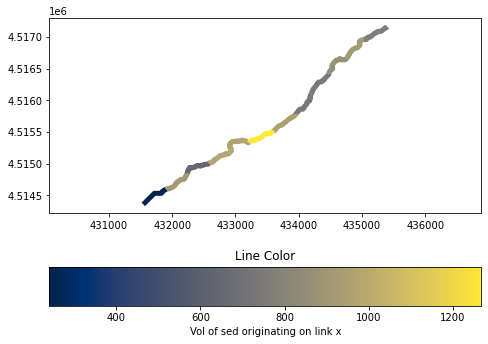

In [15]:
vol_on_link = parcels.calc_aggregate_value(
            xr.Dataset.sum,
            "volume",
            at="link",
            #filter_array=parcelfilter, # no need to filter to a specific timestep - we just have one 
            fill_value=0.0
        )

fig = plot_network_and_parcels(
    grid, parcels,
    link_attribute=vol_on_link, 
    link_attribute_title = "Vol of sed originating on link x",
    network_linewidth = 5,
    parcel_alpha = 0
)

What is the relationship between D50 and channel slope?

Text(0, 0.5, 'D50 (m)')

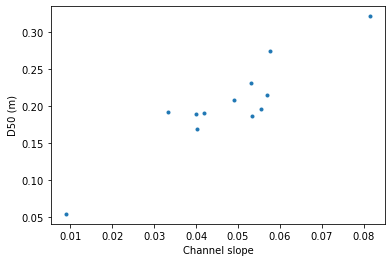

In [16]:
plt.plot(grid.at_link["channel_slope"],D50,'.')
plt.xlabel('Channel slope')
plt.ylabel('D50 (m)')